<a href="https://colab.research.google.com/github/astroviki/NumericalMethods/blob/main/GAKepler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

from astropy.table import Table


Saving CescoThetaAquilea.txt to CescoThetaAquilea (2).txt


In [2]:
data = Table.read('CescoThetaAquilea.txt', format='pandas.csv', delim_whitespace=True, names=['JD', 'Vrad', 'error'])
data

JD,Vrad,error
float64,float64,float64
7642.75,-21.8,2.5
7644.75,12.7,2.5
7647.75,-30.2,2.5
7648.71,-39.8,2.5
7648.82,-44.9,2.5
7650.68,-41.2,2.5
7652.7,-44.7,2.5
7653.78,-45.2,2.5
7656.67,-38.1,2.5


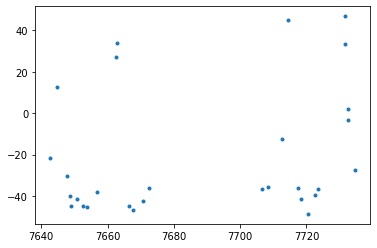

In [3]:
import matplotlib.pyplot as plt

plt.plot(data['JD'],data['Vrad'],'.')

In [4]:
!pip install pyastronomy
import numpy as np
from astropy.timeseries import LombScargle
from PyAstronomy.pyasl import foldAt

# Index of maximal radial velocity in observed data 
vrad_max_index = np.argmax(data['Vrad'])
#t0 =data['JD'][vrad_max_index]

t = data['JD']
y = data['Vrad']

y_error = data['error']

frequency, power = LombScargle(t, y).autopower()
period_estimate = 1.0/frequency[np.argmax(power)] 

print('Period estimate %.2f ' % period_estimate)

Period estimate 17.33 


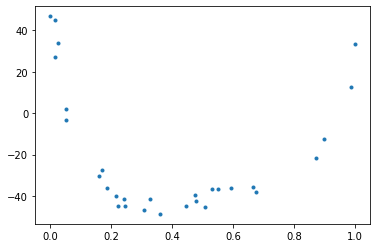

In [5]:

phase = t/period_estimate - np.floor(t/period_estimate)
sortIndexes = np.argsort(phase)
sort_x = phase[sortIndexes]
sort_y = y[sortIndexes]

phase_0 = sort_x[np.argmax(sort_y)]
sort_x = sort_x - phase_0
indxs = np.where(sort_x < 0.0)
sort_x[indxs] = sort_x[indxs]+1.0
plt.plot(sort_x,sort_y,'.')


In [6]:
print('Maximal measured radial velocity: %.2f' % (np.max(y)))
print('Minimal measured radial velocity: %.2f' % (np.min(y)))
print('Mean line radial velocity: %.2f' % (((np.max(y))+np.min(y))/2))

Maximal measured radial velocity: 46.80
Minimal measured radial velocity: -48.60
Mean line radial velocity: -0.90


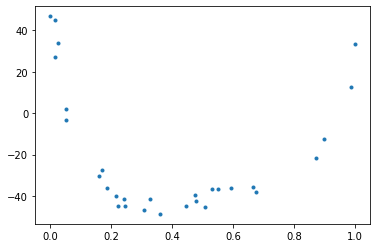

In [7]:
# Folding data using PyAstronomy method FoldAt

# Obtain the phases with respect to some
# reference point (in this case T0=217.4)
t0 = t[np.argmax(y)]
phases = foldAt(t, period_estimate, T0=t0)

# Sort with respect to phase
# First, get the order of indices ...
sortIndexes = np.argsort(phases)
# ... and, second, rearrange the arrays.
sort_phases = phases[sortIndexes]
vrad_obs = y[sortIndexes]

plt.plot(sort_phases,vrad_obs,'.')

\begin{equation}
V_{\rm rad}=K\left[\cos(\nu+\omega)+e\cos(\omega)\right]+\gamma
\end{equation}
$V_{\rm rad}$ is observed radial velocity, $K$ semi-amplitude, $e$ eccentricity, $\omega$ longitude of periastron and $\gamma$ systemic velocity of orbit.

$$
\tan\left(\frac{\nu}{2}\right)=\sqrt{\frac{1+e}{1-e}}\tan{\frac{E}{2}}
$$

$$
E - e\sin{E} = \frac{2\pi}{T}(t-\tau_0)
$$

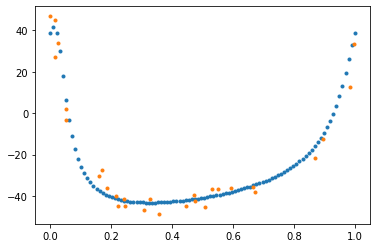

In [8]:
# Cesco Aquilae parameters
K = 42.3859
gamma = -26.5092
e = 0.65121
omega = 21.017*np.pi/180
T = 17.18

def Kepler(t):
  # Time in phase
  tau = 0.02
  T = 1.0
  E = np.zeros(np.size(t))

  for i,time in enumerate(np.nditer(t)):
    error =10.0
    while (error > 0.000001):
      buffer = E[i]
      E[i] = 2*np.pi/T*(time-tau)+e*np.sin(E[i])
      error = np.abs(E[i] - buffer)

  return E

def true_anomaly(E):
  return np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))*2

def radial_velocity(time):
  E = Kepler(time)
  nu = true_anomaly(E)
  return K*(np.cos(nu+omega)+e*np.cos(omega))+gamma

time = np.linspace(0,1.0,100)
vrad_syntetic = radial_velocity(time)

plt.plot(time,vrad_syntetic,'.')
plt.plot(sort_phases,vrad_obs,'.')




6.162492676907352


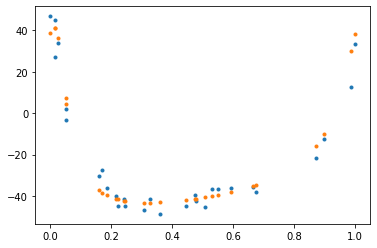

In [9]:
def residuum(vrad_syntetic,vrad):
  N = np.size(vrad)
  return np.sqrt(np.sum(np.square(vrad-vrad_syntetic))/(N-1))

vrad_syntetic = radial_velocity(sort_phases)

plt.plot(sort_phases,vrad_obs,'.')
plt.plot(sort_phases,vrad_syntetic,'.')
print(residuum(vrad_syntetic,vrad_obs))

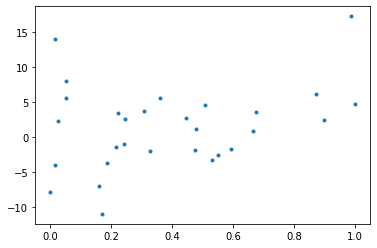

In [11]:
plt.plot(sort_phases,vrad_syntetic-vrad_obs,'.')

Solution calculated by *Single-line binary solver*

K      42.3859
\nu        

In [ ]:
def vradial_calculation(solution):

  K = solution[0]
  theta = solution[1]
  omega = solution[2]
  e = solution[3]
  gamma = solution[4]

  return K*(np.cos(theta+omega)+e*cos(omega))+gamma

def fitness_func(solution):

  vrad_calc = vradial_calculation(solution)
  
  return np.sum(np.square(vrad_calc - vrad_obs))/(N-1)


https://pypi.org/project/genetic-algorithm/

In [ ]:
!pip install genetic_algorithm
from genetic_algorithm import GeneticAlgorithm

In [ ]:
param_space = {"K": {'type': 'float', 'range':[0, 100]},
"nu": {'type': 'float', 'range':[-1, 5]},
"omega": {'type': 'int', 'range':[0, 2.0*np.pi]},
"e": {'type': 'float', 'range':[0, 1.0]},
"gamma": {'type': 'float', 'range':[-10, 10]},
}

In [13]:
data['JD'][vrad_max_index]

7731.65